# Time Series with Prophet
Prophet is a forecasting modeler built by the data science team at Facebook introduced with the "Forecasting at Scale" paper published in 2017. It is a simple, sklearn-based api that allows users with basic-knowledge to experts to quickly create a working Time Series model. It has several layers of hyperparameter tuning for those inclined to extract the most powerful model possible for their dataset.

We will be implementing a quick Time Series model using the automated features of the Prophet modeler using the ice_cream.csv file to project a couple months into the future.

### Installation for Python on Windows 10 using Anaconda

conda install -c conda-forge prophet

[see documentation for other installations processes](https://facebook.github.io/prophet/docs/installation.html#python)

In [1]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [2]:
ice_cream = pd.read_csv('data/ice_cream.csv')

In [3]:
ice_cream.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


## IMPORTANT NOTE:
Prophet will only accept a pandas Dataframe with columns named 'ds' & 'y' for the date-time data & feature value-set respectively

In [4]:
ice_cream.rename(columns={'DATE':'ds', 'IPN31152N':'y'}, inplace=True)
ice_cream['ds'] = pd.to_datetime(ice_cream.ds)
ice_cream = ice_cream.loc[(ice_cream['ds'] >= '2010-01-01')] # beginning dataset at 2010 rather than 1972
ice_cream = ice_cream.reset_index(drop=True) # reseting index to begin at 0

In [5]:
ice_cream.head()

,ds,y
0,2010-01-01,91.2895
1,2010-02-01,110.4994
2,2010-03-01,127.0971
3,2010-04-01,132.6468
4,2010-05-01,134.5576


# Train & Test Sets
we will be forecasting for the next quarter using the final three months within our dataset

In [6]:
ice_cream[-3:]

,ds,y
118,2019-11-01,79.7223
119,2019-12-01,75.7094
120,2020-01-01,83.6290


In [7]:
ic_test = ice_cream[-3:]

In [8]:
ice_cream[:-3]

,ds,y
0,2010-01-01,91.2895
1,2010-02-01,110.4994
2,2010-03-01,127.0971
3,2010-04-01,132.6468
4,2010-05-01,134.5576
...,...,...
113,2019-06-01,124.9605
114,2019-07-01,110.2632
115,2019-08-01,102.6085
116,2019-09-01,100.1741


In [9]:
ic_train = ice_cream[:-3]

# Using Prophet with our Data

In [10]:
interval=0.95

m = Prophet(interval_width=interval)
m.fit(ic_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
future = m.make_future_dataframe(periods=3,freq='MS')
future.tail()

,ds
116,2019-09-01
117,2019-10-01
118,2019-11-01
119,2019-12-01
120,2020-01-01


In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
116,2019-09-01,100.399785,91.965345,108.343539
117,2019-10-01,88.880560,81.436355,96.733276
118,2019-11-01,77.758784,69.476751,85.792880
119,2019-12-01,69.538349,62.057898,77.275242
120,2020-01-01,84.328546,76.330163,92.056418


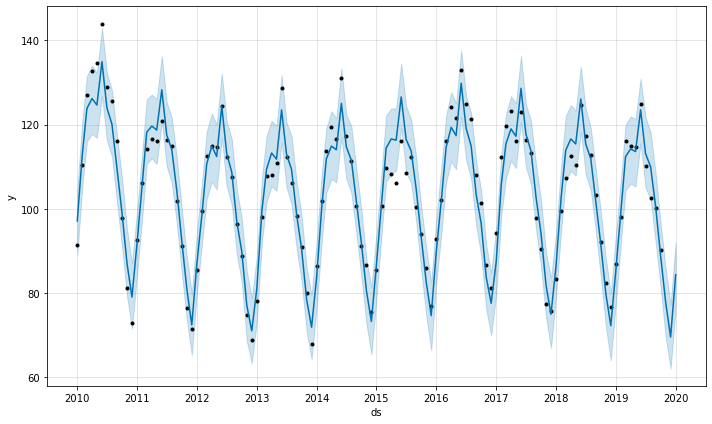

In [13]:
short_forecast = m.plot(forecast)

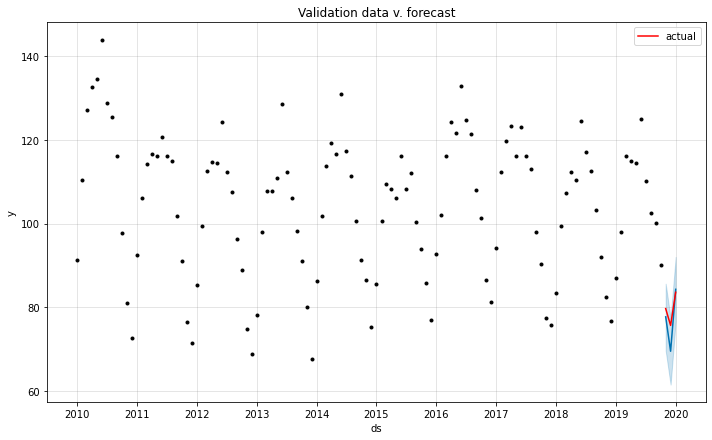

In [14]:
#actual vs. predicted
y_pred = m.predict(ic_test)
m.plot(y_pred, uncertainty=True)
plt.plot(ic_test['ds'], ic_test['y'], color='r', label='actual')
plt.title('Validation data v. forecast')
plt.legend()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


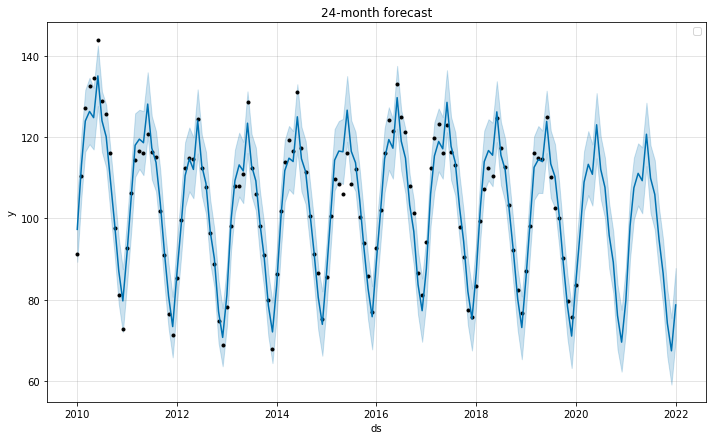

In [15]:
#long-term forecast

#tuning
interval=0.95
periods=24

#long-term model with complete dataset
m2 = Prophet(interval_width=interval)
m2.fit(ice_cream)
future2 = m2.make_future_dataframe(periods=periods, freq='MS')
forecast2 = m2.predict(future2)

#plotting long-term forecast
m2.plot(forecast2, uncertainty=True)
plt.title(f'{periods}-month forecast')
plt.legend()

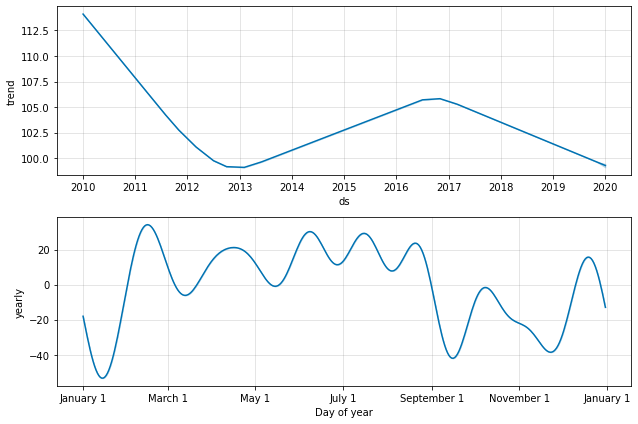

In [16]:
components = m.plot_components(forecast)

# Performance Metrics
We use standard regression metrics when evaluating the performance of a time series (e.g. Mean Absolute Error, Root Mean Squared Error,etc). A simple printout of the findings should give us some more details as to the true performance of the Prophet generated model. 

In [17]:
predictions = y_pred['yhat']
y_test = ic_test['y']
y_test = y_test.reset_index(drop=True) # resetting index due to calculation issues

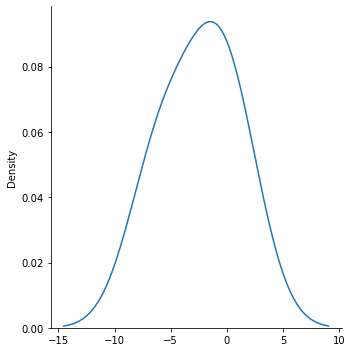

In [18]:
residuals = predictions - y_test
sns.displot(data=residuals,kind='kde')

In [19]:
from sklearn import metrics
import numpy as np

MAE = metrics.mean_absolute_error(y_test,predictions)
MAPE = metrics.mean_absolute_percentage_error(y_test,predictions) * 100
MSE = metrics.mean_squared_error(y_test,predictions)
RMSE = np.sqrt(metrics.mean_squared_error(y_test,predictions))
MedAE = metrics.median_absolute_error(y_test,predictions)
MedAPE = np.median((np.abs(np.subtract(y_test, predictions)/ y_test))) * 100

In [20]:
print('MAE:', np.round(MAE,2))
print('MAPE:', np.round(MAPE,2),'%')
print('MSE:', np.round(MSE,2))
print('RMSE:', np.round(RMSE,2))
print('MedAE:', np.round(MedAE,2))
print('MedAPE:',np.round(MedAPE,2),'%')

MAE: 2.94
MAPE: 3.82 %
MSE: 14.14
RMSE: 3.76
MedAE: 1.96
MedAPE: 2.46 %


# Conclusion
The numbers in our performance metrics seem to indicate that the model performed well. Emphasis should be placed on the percentage error metrics as they will tell us a more concrete story about how well the model performed. With a MAPE (Mean Absolute Percentage Error) of only 3.82% and a MedAPE (Median Absolute Percentage Error) of just 2.46% the model did very well. We can see that even in a long forecast the model seems to have captured the overall ebb and flow of the dataset. Overall, these findings can give us confidence to potentially deploy this model into production.